# Clustering Geolocation Data Intelligently in Python
We have real life dataset that includes taxi rank locations in the city of Johannesburg, South Africa. A taxi rank is simply a location from which a collection of taxis have a base of operations and where they are stored when they are not in use. Our task is to pin-point locations where service centers can be built to best accomodate as many taxis as possible based on these locations. We will cluster these taxi rank locations and a simple way would be to simply build a service center at the center or the centroid of each cluster, and these service center will then serve all texis that belong to that cluster. On the outcome, each circle will be representing a single taxi rank and the color of that circle is representing all members that exists within that cluster. 

In simple, We have taxi rank locations, and want to define key clusters of these taxis where we can build service stations for all taxis operating in that region.

## Project Outline

[**1**](#1): Exploratory Data Analysis

[**2**](#2): Visualizing Geographical Data

[**3**](#3): Clustering Strength / Performance Metric

[**4**](#4): K-Means Clustering

[**5**](#5): DBSCAN

[**6**](#6): HDBSCAN

[**7**](#7): Addressing Outliers

[**Further Reading**](#further)

In [2]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

from ipywidgets import interactive

from collections import defaultdict

import hdbscan
import folium
import re


cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10

<a id='1'></a>
# 1. Exploratory Data Analysis

In [3]:
df = pd.read_csv('Data/taxi_data.csv')

In [4]:
df.head()

LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

In [5]:
df.duplicated(subset=['LON', 'LAT']).values.any()

True

In [6]:
df.isna().values.any()

True

In [7]:
print(f'Before dropping NaNs and dupes\t:\tdf.shape = {df.shape}')
df.dropna(inplace=True)
df.drop_duplicates(subset=['LON', 'LAT'], keep='first', inplace=True)
print(f'After dropping NaNs and dupes\t:\tdf.shape = {df.shape}')

Before dropping NaNs and dupes	:	df.shape = (838, 3)
After dropping NaNs and dupes	:	df.shape = (823, 3)


In [8]:
df.head()

LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

In [46]:
#Extracting the longitude and latitude as an array
X = np.array(df[['LON', 'LAT']], dtype='float64')
X

array([[ 28.17858, -25.73882],
       [ 28.1766 , -25.73795],
       [ 27.83239, -26.53722],
       ...,
       [ 27.83991, -26.24235],
       [ 27.86166, -26.23624],
       [ 28.39097, -26.30931]])

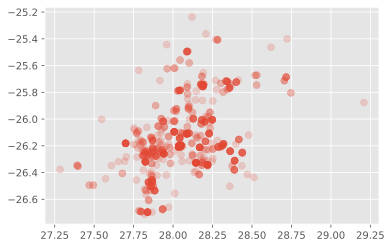

In [10]:
plt.scatter(X[:,0], X[:,1], alpha=0.2, s=50) #alpha=0.2, to see if there is any overlapping data

<a id='2'></a>
# 2. Visualizing Geographical Data


In [49]:
m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, 
               tiles='Stamen Toner')

#Since it returns a tuple of the row number that you're looking at, and the actual row information. And we don't care about the row number so much so just putting an "_"
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row.LAT, row.LON],
        radius=5,
        popup=re.sub(r'[^a-zA-Z ]+', '', row.NAME),
        color='#1787FE',
        fill=True,
        fill_colour='#1787FE'
    ).add_to(m)

In [50]:
m

<a id='3'></a>
# 3. Clustering Strength / Performance Metric

In [13]:
X_blobs, _ = make_blobs(n_samples=1000, centers=10, n_features=2, 
                        cluster_std=0.5, random_state=4)

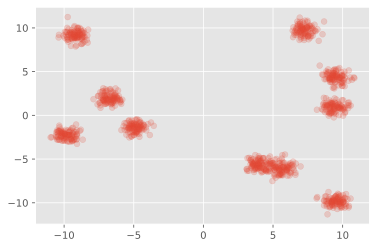

In [14]:
plt.scatter(X_blobs[:,0], X_blobs[:,1], alpha=0.2) #1st and 2nd component of the array

In [15]:
class_predictions = np.load('Data/sample_clusters.npy')

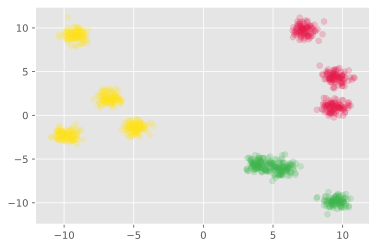

In [16]:
unique_clusters = np.unique(class_predictions)
for unique_cluster in unique_clusters:
    X = X_blobs[class_predictions==unique_cluster] #clever indexing
    plt.scatter(X[:,0], X[:,1], alpha=0.2, c=cols[unique_cluster])

In [17]:
silhouette_score(X_blobs, class_predictions) #Assigns a score between -1 to +1 to a clustering result. The closer it is to 1, the better the clustering is. It basically checks how well clustered any single one point is compared to the center of an opposing cluster 

0.6657220862867241

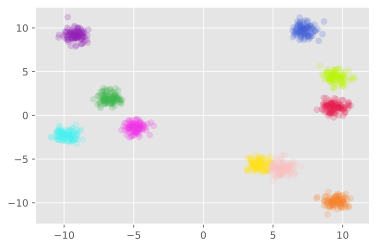

In [18]:
class_predictions = np.load('Data/sample_clusters_improved.npy')
unique_clusters = np.unique(class_predictions)
for unique_cluster in unique_clusters:
    X = X_blobs[class_predictions==unique_cluster]
    plt.scatter(X[:,0], X[:,1], alpha=0.2, c=cols[unique_cluster])

In [19]:
silhouette_score(X_blobs, class_predictions)

0.7473587799908298

<a id='4'></a>
# 4. K-Means Clustering

In [20]:
X_blobs, _ = make_blobs(n_samples=1000, centers=50, 
                        n_features=2, cluster_std=1, random_state=4)

In [21]:
data = defaultdict(dict)
for x in range(1,21):
    model = KMeans(n_clusters=3, random_state=17, 
                   max_iter=x, n_init=1).fit(X_blobs)
    
    data[x]['class_predictions'] = model.predict(X_blobs)
    data[x]['centroids'] = model.cluster_centers_
    data[x]['unique_classes'] = np.unique(class_predictions)

In [22]:
def f(x):
    class_predictions = data[x]['class_predictions']
    centroids = data[x]['centroids']
    unique_classes = data[x]['unique_classes']

    for unique_class in unique_classes:
            plt.scatter(X_blobs[class_predictions==unique_class][:,0], 
                        X_blobs[class_predictions==unique_class][:,1], 
                        alpha=0.3, c=cols[unique_class])
    plt.scatter(centroids[:,0], centroids[:,1], s=200, c='#000000', marker='v')
    plt.ylim([-15,15]); plt.xlim([-15,15])
    plt.title('How K-Means Clusters')

interactive_plot = interactive(f, x=(1, 20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=10, description='x', max=20, min=1), Output(layout=Layout(height='350px'…

In [23]:
X = np.array(df[['LON', 'LAT']], dtype='float64')
k = 70
model = KMeans(n_clusters=k, random_state=17).fit(X)
class_predictions = model.predict(X)
df[f'CLUSTER_kmeans{k}'] = class_predictions

In [24]:
df.head()

LON       LAT                          NAME  CLUSTER_kmeans70
0  28.17858 -25.73882         11th Street Taxi Rank                 1
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank                 1
2  27.83239 -26.53722          Adams Road Taxi Rank                 9
3  28.12514 -26.26666  Alberton City Mall Taxi Rank                 8
4  28.10144 -26.10567      Alexandra Main Taxi Rank                 4

In [25]:
def create_map(df, cluster_column):
    m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')

    for _, row in df.iterrows():

        if row[cluster_column] == -1:
            cluster_colour = '#000000'
        else:
            cluster_colour = cols[row[cluster_column]]

        folium.CircleMarker(
            location= [row['LAT'], row['LON']],
            radius=5,
            popup= row[cluster_column],
            color=cluster_colour,
            fill=True,
            fill_color=cluster_colour
        ).add_to(m)
        
    return m

m = create_map(df, 'CLUSTER_kmeans70')
print(f'K={k}')
print(f'Silhouette Score: {silhouette_score(X, class_predictions)}')

m.save('kmeans_70.html')

K=70
Silhouette Score: 0.6527069281516621


In [26]:
m

In [27]:
best_silhouette, best_k = -1, 0

for k in tqdm(range(2, 100)):
    model = KMeans(n_clusters=k, random_state=1).fit(X)
    class_predictions = model.predict(X)
    
    curr_silhouette = silhouette_score(X, class_predictions)
    if curr_silhouette > best_silhouette:
        best_k = k
        best_silhouette = curr_silhouette
        
print(f'K={best_k}')
print(f'Silhouette Score: {best_silhouette}') 

100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:47<00:00,  2.05it/s]

K=99
Silhouette Score: 0.708499624089545


<a id='5'></a>
# 5. DBSCAN 
Density-Based Spatial Clustering of Applications with Noise

In [28]:
# code for indexing out certain values #singleton cluster
dummy = np.array([-1, -1, -1, 2, 3, 4, 5, -1]) #-1 are the noise 

new = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(dummy)])

In [29]:
model = DBSCAN(eps=0.01, min_samples=5).fit(X)
class_predictions = model.labels_

df['CLUSTERS_DBSCAN'] = class_predictions

In [51]:
m = create_map(df, 'CLUSTERS_DBSCAN')

    
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

Number of clusters found: 66
Number of outliers found: 0
Silhouette ignoring outliers: 0.5849126493146242
Silhouette outliers as singletons: 0.5849126493146242


In [31]:
m

### Limitations
* DBSCAN algorithm fails in case of varying density clusters.
* Fails in case of neck type of dataset.
* Does not work well in case of high dimensional data.

<a id='6'></a>
# 6. HDBSCAN
Hierarchical DBSCAN

In [32]:
model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2, 
                        cluster_selection_epsilon=0.01)
#min_cluster_size
#min_samples
#cluster_selection_epsilon

class_predictions = model.fit_predict(X)
df['CLUSTER_HDBSCAN'] = class_predictions

In [33]:
m = create_map(df, 'CLUSTER_HDBSCAN')

print(f'Number of clusters found: {len(np.unique(class_predictions))-1}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

m

Number of clusters found: 66
Number of outliers found: 102
Silhouette ignoring outliers: 0.7670504354649553
Silhouette outliers as singletons: 0.6389924831127337


In [34]:
hdbscan.HDBSCAN?

<a id='7'></a>
# 7. Addressing Outliers

In [35]:
classifier = KNeighborsClassifier(n_neighbors=1)

In [36]:
df_train = df[df.CLUSTER_HDBSCAN!=-1]
df_predict = df[df.CLUSTER_HDBSCAN==-1]

In [37]:
X_train = np.array(df_train[['LON', 'LAT']], dtype='float64')
y_train = np.array(df_train['CLUSTER_HDBSCAN'])

X_predict = np.array(df_predict[['LON', 'LAT']], dtype='float64')

In [38]:
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [39]:
predictions = classifier.predict(X_predict)

In [53]:
predictions

array([26, 41, 13, 44, 57, 26, 34,  4, 60, 60, 16, 16, 61, 24, 51, 51, 51,
       58, 41, 63, 13, 45, 15, 45, 45,  6,  0, 17, 26, 26, 26, 49, 49, 53,
       49, 13, 61, 26, 26, 39, 65, 31, 31, 31,  0, 46, 46, 21, 58, 60,  6,
        5, 24,  1, 63, 34, 64, 36, 36, 16,  7,  3, 64, 41, 13, 39, 39, 39,
       41, 40, 40, 25, 59, 57, 61, 61, 62, 26, 15, 15, 59, 63,  6, 19, 61,
       61, 48,  4, 41, 21, 64, 64, 64, 61, 61, 21, 23, 38, 31, 41, 55, 55],
      dtype=int64)

In [40]:
df['CLUSTER_hybrid'] = df['CLUSTER_HDBSCAN']

In [41]:
df.loc[df.CLUSTER_HDBSCAN==-1, 'CLUSTER_hybrid'] = predictions

In [42]:
m = create_map(df, 'CLUSTER_hybrid')

In [43]:
m

In [44]:
class_predictions = df.CLUSTER_hybrid
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Silhouette: {silhouette_score(X, class_predictions)}')

m.save('hybrid.html')

Number of clusters found: 66
Silhouette: 0.5849126493146242


Text(0.5, 0, 'Cluster Sizes')

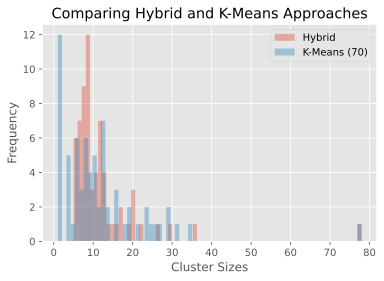

In [45]:
df['CLUSTER_hybrid'].value_counts().plot.hist(bins=70, alpha=0.4, 
                                              label='Hybrid')
df['CLUSTER_kmeans70'].value_counts().plot.hist(bins=70, alpha=0.4,
                                               label='K-Means (70)')
plt.legend()
plt.title('Comparing Hybrid and K-Means Approaches')
plt.xlabel('Cluster Sizes')

Note: Hybrid approach has generally larger clusters. Now, what that suggests is that we are dealing with more information that's relevant and it gives us more understanding with a better approach to building these service stations for the Taxi ranks. It just means that our clusters are generally richer. And because we know, it's a density based approach it has more value and backing in terms of mathematics behind it. Now again, in some use cases, you might prefer to use K-means over this Hybrid approach, it's definitely simpler to implement that you have to give it that value k=70, which I wasn't able to aquire based on DBSCAN algo.

<a id='further'></a>
# Further Reading

For some additional reading, feel free to check out [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), and [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/) clustering respectively.

It may be of use to also check out [other forms of clustering](https://scikit-learn.org/stable/modules/clustering.html) that are commonly used and available in the scikit-learn library. HDBSCAN documentation also includes [a good methodology](https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html) for choosing your clustering algorithm based on your dataset and other limiting factors.

1. Why was Exploratory Data Analysis useful for our project?
- NaNs (nulls) will break the model if they are not removed since ML models need numbers explicitly.
- Removing duplicates will prevent faulty clusters from forming. False duplicate locations could bias our models, especially our density-based ones.


2. The K-Means algorithm will find the optimal number of clusters, k.
- False, K-Means clusters iteratively but needs to be told how many clusters, k, to find.
- This is one of the limitations of the K-Means algorithm and is what prompts us to use more advanced, density-based approaches.


3. K-Means will always result in the same answer, given enough iterations to run.
- False, because the K-Means algorithm starts with random values, and these can result in different clustering results even after many iterations.
- K-Means is highly dependent on this random first iteration, and while most times results might be highly similar, there is no guaranteee that they will be the same.


4. HDBSCAN is an improvement over DBSCAN by finding the optimal hyperparameters for DBSCAN to run most effectively.
- False. HDBSCAN basically uses DBSCAN with different hyperparameters to find different levels of density in a given dataset.


5. Outliers don't necessarily have to be dealt with in all clustering algorithms. We had to define a way of dealing with them for our specific use case.


6. Treating outliers as singletons was necessary to get a valid value for our Silhouette Scores. Here, We treated outliers as single-sample clusters so as to not treat all outliers as one big cluster.